In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk

In [2]:
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [3]:
from plotly import graph_objs as go
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm

In [4]:
train_raw = pd.read_parquet('data/train.parquet').reset_index(drop=True)
test_raw = pd.read_parquet('data/test.parquet').reset_index(drop=True)

In [9]:
train.head()

,Body,Tags,Title,target
0,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
1,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
2,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
3,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
4,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [12]:
tags = pd.read_csv('preproc_files/train_tags.csv')

In [13]:
tags.head()

,t_regression,t_variables,t_laravel-5,t_azure-cosmosdb,t_sql-server,t_selenium-webdriver,t_calculator,t_devops,t_mergesort,t_realm,...,t_textbox,t_primes,t_spring,t_mod-rewrite,t_hardware,t_task,has_code,has_markdown,length,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.027771,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-0.512625,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0.151526,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0.301407,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,-0.461748,1


Тэгов очевидно слишком много. Посмотрим, как они коррелируют с классом, и избавимся от тех, которые коррелируют слишком слабо.

In [160]:
def estimate_class_correlation(df):
    correlation = []
    for column in df.drop('class', axis=1).columns:
        correlation.append((column, abs(df['class'].corr(df[column]))))
    return sorted(correlation, key=lambda x: x[1])[::-1]

In [26]:
estimate_class_correlation(tags)

[('has_code', 0.6201006858403915),
 ('has_markdown', 0.5448033232980418),
 ('t_sql', 0.1523608721741436),
 ('length', 0.14927851073362738),
 ('t_reactjs', 0.12891627307103698),
 ('t_sql-server', 0.12231551128864296),
 ('t_docker', 0.11456172216110617),
 ('t_typescript', 0.11079193580239821),
 ('t_types', 0.11070372205247896),
 ('t_angular', 0.11003049298902652),
 ('t_r', 0.10647186968821029),
 ('t_react-native', 0.10239659615485192),
 ('t_native', 0.10187948156912176),
 ('t_flutter', 0.09740841578373438),
 ('t_server', 0.09609619392692757),
 ('t_vba', 0.09363128757220057),
 ('t_html', 0.09344376355103158),
 ('t_.net-core', 0.09155792163421038),
 ('t_excel', 0.09071881050929302),
 ('t_php', 0.0883220461495577),
 ('t_git', 0.08621036550516945),
 ('t_jquery', 0.08098808749493525),
 ('t_vue.js', 0.08042528206347742),
 ('t_arrays', 0.08015826641563441),
 ('t_dart', 0.07899492346103064),
 ('t_node.js', 0.07874247256370288),
 ('t_visual-studio-code', 0.07793785218652476),
 ('t_service', 0.077

In [30]:
to_remove = [p[0] for p in correlation if p[1] < 0.01]

In [32]:
train_tags = tags
test_tags = pd.read_csv('preproc_files/test_tags.csv')

In [33]:
train_tags = train_tags.drop(to_remove, axis=1)
test_tags = test_tags.drop(to_remove, axis=1)

In [35]:
train_misc = train_tags[['has_code', 'has_markdown', 'length', 'class']]
test_misc = test_tags[['has_code', 'has_markdown', 'length']]
train_tags = train_tags.drop(['has_code', 'has_markdown', 'length', 'class'], axis=1)
test_tags = test_tags.drop(['has_code', 'has_markdown', 'length'], axis=1)

In [36]:
train_misc.head()

,has_code,has_markdown,length,class
0,0,1,0.027771,2
1,0,0,-0.512625,2
2,1,1,0.151526,0
3,1,1,0.301407,0
4,1,1,-0.461748,1


In [37]:
test_misc.head()

,has_code,has_markdown,length
0,0,1,-0.300980
1,1,1,-0.330390
2,0,1,-0.478665
3,1,1,0.001697
4,0,0,-0.450481


А здесь избавимся от тэгов которые слишком сильно коррелируют друг с другом.

In [44]:
train_corr = train_tags.corr()

In [45]:
columns = np.full((train_corr.shape[0],), True)
for i in range(train_corr.shape[0]):
    for j in range(i+1, train_corr.shape[0]):
        if train_corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

In [47]:
selected_columns = train_tags.columns[columns]

In [49]:
train_tags = train_tags[selected_columns]
test_tags = test_tags[selected_columns]

### Ad-hoc фичи

### 1) Доля неграмотно написанных слов

In [52]:
from spellchecker import SpellChecker

In [56]:
spell = SpellChecker()

In [67]:
train_texts = pd.read_csv('data/train_non_lemmatized.csv')
test_texts = pd.read_csv('data/test_non_lemmatized.csv')

In [68]:
def misspell_proportion(text):
    text = text.split()
    misspelled = spell.unknown(text)
    return len(misspelled) / len(text)

In [65]:
train_misspelled = list(map(misspell_proportion, train_texts['text']))
test_misspelled = list(map(misspell_proportion, test_texts['text']))

In [70]:
train_misc['misspelled'] = train_misspelled
test_misc['misspelled'] = test_misspelled

In [74]:
estimate_class_correlation(train_misc)

[('has_code', 0.6201006858403915),
 ('has_markdown', 0.5448033232980418),
 ('misspelled', 0.26187857997750746),
 ('length', 0.14927851073362738)]

### 2) Доля кода на пост

In [78]:
def code_proportion(text):
    no_multiwhite = re.sub(r'\s+', ' ', text.replace('\n', ' '))
    no_code = re.sub(r'<code>.+?<\/code>', '', no_multiwhite)
    return 1 - (len(no_code) / len(text))

In [79]:
train_code = list(map(code_proportion, train['Body']))
test_code = list(map(code_proportion, test['Body']))

In [81]:
train_misc['code_prop'] = train_code
test_misc['code_prop'] = test_code

In [82]:
estimate_class_correlation(train_misc)

[('has_code', 0.6201006858403915),
 ('has_markdown', 0.5448033232980418),
 ('code_prop', 0.3374108476161797),
 ('misspelled', 0.26187857997750746),
 ('length', 0.14927851073362738)]

In [84]:
train_misc['has_code'].corr(train_misc['code_prop'])

0.756199524529486

Наличие кода в принципе очень сильно коррелирует с его долей в тексте и больше коррелирует с классом, так что оставим только наличие / отсутствие.

In [85]:
train_misc = train_misc.drop('code_prop', axis=1)
test_misc = test_misc.drop('code_prop', axis=1)

### 3. Sentiment analysis

In [86]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import PorterStemmer

In [97]:
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [98]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [99]:
def get_sentiment(word,tag):
    """ returns list of pos neg and objective score. But returns empty list if not present in senti wordnet. """

    wn_tag = penn_to_wn(tag)
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

In [100]:
ps = PorterStemmer()

In [111]:
def evaluate_sentiment(text):
    text = text.split()
    pos_val = nltk.pos_tag(text)
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    senti_val = [s for s in senti_val if s]
    total_pos = sum([s[0] for s in senti_val]) / len(text)
    total_neg = sum([s[1] for s in senti_val]) / len(text)
    total_obj = sum([s[2] for s in senti_val]) / len(text)
    return total_pos, total_neg, total_obj

In [117]:
train_pos, test_pos = [], []
train_neg, test_neg = [], []
train_obj, test_obj = [], []

In [118]:
for t in tqdm(train_texts['text']):
    sent = evaluate_sentiment(t)
    train_pos.append(sent[0])
    train_neg.append(sent[1])
    train_obj.append(sent[2])

100%|██████████| 48000/48000 [04:02<00:00, 197.99it/s]


In [119]:
for t in tqdm(test_texts['text']):
    sent = evaluate_sentiment(t)
    test_pos.append(sent[0])
    test_neg.append(sent[1])
    test_obj.append(sent[2])

100%|██████████| 12000/12000 [01:01<00:00, 193.95it/s]


In [120]:
train_misc['pos'] = train_pos
train_misc['neg'] = train_neg
train_misc['obj'] = train_obj

In [121]:
test_misc['pos'] = test_pos
test_misc['neg'] = test_neg
test_misc['obj'] = test_obj

In [122]:
estimate_class_correlation(train_misc)

[('has_code', 0.6201006858403915),
 ('has_markdown', 0.5448033232980418),
 ('misspelled', 0.26187857997750746),
 ('obj', 0.1862405161828453),
 ('length', 0.14927851073362738),
 ('neg', 0.06411125349823509),
 ('pos', 0.05541453821559351)]

In [123]:
train_misc['pos'].corr(train_misc['neg'])

0.20144979805165356

In [124]:
train_misc['pos'].corr(train_misc['obj'])

0.15098939629845057

In [125]:
train_misc['neg'].corr(train_misc['obj'])

0.013257136913493782

Корреляция между ними не такая уж и большая, так что оставим все три.

### 4. Punctuation per word

In [130]:
def remove_markdown(text):
    no_multiwhite = re.sub(r'\s+', ' ', text.replace('\n', ' '))
    no_code = re.sub(r'<code>.+?<\/code>', '', no_multiwhite)
    no_markdown = re.sub(r'<\/?.+?>', '', no_code).strip()
    return no_markdown

In [131]:
p = set(string.punctuation)

In [138]:
def punctuation_per_word(text):
    text = remove_markdown(text)
    punctuation = sum(ch in p for ch in text)
    text = ''.join(ch for ch in text.lower() if ch.isalpha() or ch == ' ').split()
    if len(text) > 0:
        return punctuation / len(text)
    else:
        return(0)

In [139]:
train_punct = list(map(punctuation_per_word, train['Body']))
test_punct = list(map(punctuation_per_word, test['Body']))

In [141]:
train_misc['punct'] = train_punct
test_misc['punct'] = test_punct

In [142]:
estimate_class_correlation(train_misc)

[('has_code', 0.6201006858403915),
 ('has_markdown', 0.5448033232980418),
 ('misspelled', 0.26187857997750746),
 ('obj', 0.1862405161828453),
 ('punct', 0.16855857202924968),
 ('length', 0.14927851073362738),
 ('neg', 0.06411125349823509),
 ('pos', 0.05541453821559351)]

### 5) Длина заголовка в словах
(в символах корреляция с классом ниже 0.01 + они коррелируют друг с другом)

In [148]:
train_title_ch = list(map(len, train['Title']))
test_title_ch = list(map(len, test['Title']))

In [151]:
train_title_w = [len(t.split()) for t in train['Title']]
test_title_w = [len(t.split()) for t in test['Title']]

In [153]:
train_misc['title_w'] = train_title_w 
train_misc['title_ch'] = train_title_ch

In [154]:
estimate_class_correlation(train_misc)

[('has_code', 0.6201006858403915),
 ('has_markdown', 0.5448033232980418),
 ('misspelled', 0.26187857997750746),
 ('obj', 0.1862405161828453),
 ('punct', 0.16855857202924968),
 ('length', 0.14927851073362738),
 ('title_w', 0.11831425052956365),
 ('neg', 0.06411125349823509),
 ('pos', 0.05541453821559351),
 ('title_ch', 0.005702767712076371)]

In [155]:
train_misc = train_misc.drop('title_ch', axis=1)

In [156]:
test_misc['title_w'] = test_title_w

In [157]:
train_misc.head()

,has_code,has_markdown,length,class,misspelled,pos,neg,obj,punct,title_w
0,0,1,0.027771,2,0.100000,0.010417,0.014583,0.425000,0.308511,18
1,0,0,-0.512625,2,0.105263,0.026316,0.059211,0.546053,0.150000,13
2,1,1,0.151526,0,0.214953,0.035047,0.007009,0.434579,0.151786,12
3,1,1,0.301407,0,0.213115,0.029713,0.017418,0.362705,0.158333,11
4,1,1,-0.461748,1,0.185185,0.018519,0.027778,0.398148,0.227273,17


In [158]:
column_order = ['has_code', 'has_markdown', 'punct', 'length', 'title_w', 'misspelled', 'pos', 'neg', 'obj', 'class']

In [166]:
train_misc = train_misc[column_order].rename({'length': 'text_length', 'title_w': 'title_length'}, axis=1)

In [167]:
train_misc.head()

,has_code,has_markdown,punct,text_length,title_length,misspelled,pos,neg,obj,class
0,0,1,0.308511,0.027771,18,0.100000,0.010417,0.014583,0.425000,2
1,0,0,0.150000,-0.512625,13,0.105263,0.026316,0.059211,0.546053,2
2,1,1,0.151786,0.151526,12,0.214953,0.035047,0.007009,0.434579,0
3,1,1,0.158333,0.301407,11,0.213115,0.029713,0.017418,0.362705,0
4,1,1,0.227273,-0.461748,17,0.185185,0.018519,0.027778,0.398148,1


In [168]:
test_misc = test_misc[column_order[:-1]].rename({'length': 'text_length', 'title_w': 'title_length'}, axis=1)

In [170]:
train_misc.to_csv('data/train_misc.csv', index=False)
test_misc.to_csv('data/test_misc.csv', index=False)

In [171]:
train_tags.head()

,t_variables,t_laravel-5,t_azure-cosmosdb,t_sql-server,t_selenium-webdriver,t_calculator,t_devops,t_realm,t_post,t_ionic2,...,t_amazon-cloudformation,t_jwt,t_safari,t_fibonacci,t_build,t_containers,t_recaptcha,t_textbox,t_primes,t_spring
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
train_features = pd.concat([train_tags, train_misc], axis=1)
test_features = pd.concat([test_tags, test_misc], axis=1)

In [178]:
train_class = train_features['class']
train_features = train_features.drop('class', axis=1)

In [184]:
train_features.to_csv('data/train_features.csv', index=False)
test_features.to_csv('data/test_features.csv', index=False)

Пока хватит, может, ещё придумою

In [220]:
train_tags.to_csv('preproc_files/train_tags.csv', index=False)
test_tags.to_csv('preproc_files/test_tags.csv', index=False)

С этим набором фичей точность улучшилась ещё примерно на 1.5%, но потом я пошёл на второй заход.

# Round 2

Здесь я уже решил выделить наиболее часто встречающиеся 1-2-3-граммы.

In [5]:
train_raw = pd.read_parquet('data/train.parquet').reset_index(drop=True)
test_raw = pd.read_parquet('data/test.parquet').reset_index(drop=True)

In [10]:
train_raw.head()

,Body,Tags,Title,target
0,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
1,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
2,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
3,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
4,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [7]:
train_features = pd.read_csv('preproc_files/train_features.csv')
test_features = pd.read_csv('preproc_files/test_features.csv')

In [11]:
train_features.head()

,t_variables,t_laravel-5,t_azure-cosmosdb,t_sql-server,t_selenium-webdriver,t_calculator,t_devops,t_realm,t_post,t_ionic2,...,t_spring,has_code,has_markdown,punct,text_length,title_length,misspelled,pos,neg,obj
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0.308511,0.027771,18,0.100000,0.010417,0.014583,0.425000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0.150000,-0.512625,13,0.105263,0.026316,0.059211,0.546053
2,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0.151786,0.151526,12,0.214953,0.035047,0.007009,0.434579
3,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0.158333,0.301407,11,0.213115,0.029713,0.017418,0.362705
4,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0.227273,-0.461748,17,0.185185,0.018519,0.027778,0.398148


In [9]:
train_texts = pd.read_csv('data/train_lemmatized.csv')
test_texts = pd.read_csv('data/test_lemmatized.csv')

In [12]:
train_texts.head()

,target,text,tags
0,2,implementing minimum spanning forrest algorihm...,<java><algorithm><graph-algorithm>
1,2,r studio date getting converted number making ...,<html><r><dataframe>
2,0,panda dataframe groupby get sum multiple colum...,<python><pandas><dataframe><pandas-groupby>
3,0,casting result observableforkjoin respective t...,<angular><typescript><rxjs>
4,1,environment variable set batch file accessed c...,<c><windows><batch-file>


In [33]:
texts0 = train_texts[train_texts['target'] == 0]['text']
texts1 = train_texts[train_texts['target'] == 1]['text']
texts2 = train_texts[train_texts['target'] == 2]['text']

In [72]:
from collections import Counter

In [119]:
def frequent_uni(texts):
    for text in texts:
        text = ' '.join(set(text.split()))
    texts = ' '.join(texts).split()
    count = Counter(texts)
    return count.most_common(200)

Следующая функция определяет, какие n-граммы общие хотя бы для одной пары классов, и исключает их из рассмотрения (мы берём только топ уникальных n-грамм).

In [120]:
def sort_features(function, top_w):
    com0 = function(texts0)
    com1 = function(texts1)
    com2 = function(texts2)
    
    i01 = set([p[0] for p in com0]).intersection([p[0] for p in com1])
    i02 = set([p[0] for p in com0]).intersection([p[0] for p in com2])
    i12 = set([p[0] for p in com1]).intersection([p[0] for p in com2])
    i012 = (set([p[0] for p in com0]).intersection([p[0] for p in com1])).intersection([p[0] for p in com2])
    i_com = i01.union(i02).union(i12).union(i012)
    
    com0 = [c[0] for c in com0 if c[0] not in i_com][:min(top_w, len(com0))]
    com1 = [c[0] for c in com1 if c[0] not in i_com][:min(top_w, len(com1))]
    com2 = [c[0] for c in com2 if c[0] not in i_com][:min(top_w, len(com2))]
    
    return com0 + com1 + com2

In [121]:
com_uni = sort_features(frequent_uni, 10)

In [122]:
com_uni

['version',
 'component',
 'build',
 'default',
 'request',
 'running',
 'react',
 'ul',
 'module',
 'api',
 'ltlt',
 'relnofollow',
 'ltdiv',
 'ampamp',
 'website',
 'l',
 'random',
 'say',
 'endl',
 'point',
 'thanks',
 'sql',
 'override',
 'td',
 'def',
 'click',
 'br',
 'tr',
 'width',
 'link']

In [123]:
def frequent_bi(texts):
    bigrams = []
    for text in texts:
        bigrams += list(set([' '.join(b) for l in [text] for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]))
    count = Counter(bigrams)
    return count.most_common(100)

In [127]:
com_bi = sort_features(frequent_bi, 10)

In [128]:
com_bi

['pim using',
 'visual studio',
 'codepre phowever',
 'get following',
 'pi possible',
 'id like',
 'codepre pin',
 'following errorp',
 'following error',
 'error p',
 'relnofollow noreferrerimg',
 'return codepre',
 'c pi',
 'cout ltlt',
 'python pi',
 'int lt',
 'pthanks advancep',
 'pi new',
 'thank youp',
 'pthank youp',
 'enter image',
 'thanks advance',
 'end snippet',
 'begin snippet',
 'snippet j',
 'j hide',
 'hide false',
 'false language',
 'false console',
 'console true']

In [104]:
from nltk.util import trigrams
from itertools import chain

In [129]:
def frequent_tri(texts):
    trig = [list(set([' '.join(t) for t in trigrams(text.split())])) for text in texts]
    trig = list(chain(*trig))
    count = Counter(trig)
    return count.most_common(50)

In [133]:
com_tri = sort_features(frequent_tri, 10)

In [135]:
freq_features = com_uni + com_bi + com_tri

In [144]:
def extract_freq_features(texts):
    rows = []
    for text in texts:
        row = {}
        t_u = text.split()
        for u in com_uni:
            row[u] = int(u in t_u)
        t_b = [' '.join(b) for l in [text] for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
        for b in com_bi:
            row[b] = int(b in t_b)
        t_t = [' '.join(t) for t in trigrams(text.split())]
        for t in com_tri:
            row[t] = int(t in t_t)
        rows.append(row)
    return rows

In [146]:
train_common_words = extract_freq_features(train_texts['text'])
test_common_words = extract_freq_features(test_texts['text'])

In [157]:
train_c_w = pd.DataFrame(train_common_words)
test_c_w = pd.DataFrame(test_common_words)

In [151]:
train_corr = train_c_w.corr()

In [152]:
columns = np.full((train_corr.shape[0],), True)
for i in range(train_corr.shape[0]):
    for j in range(i+1, train_corr.shape[0]):
        if train_corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False

In [154]:
selected_columns = train_c_w.columns[columns]

In [158]:
train_c_w = train_c_w[selected_columns]
test_c_w = test_c_w[selected_columns]

In [159]:
train_c_w['class'] = train_texts['target']

In [162]:
correlation = estimate_class_correlation(train_c_w)

In [163]:
correlation = [corr[0] for corr in correlation if corr[1] >= 0.01]

In [165]:
train_c_w = train_c_w[correlation]
test_c_w = test_c_w[correlation]

In [166]:
train_c_w.head()

,thanks,enter image,component,react,version,build,sql,thanks advance,default,pim using,...,ltbodygt lthtmlgt codepre,python pi,width,codepre pi need,ltlt,pi want create,l,website,override,pi want make
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
train_features = pd.concat([train_features, train_c_w], axis=1)
test_features = pd.concat([test_features, test_c_w], axis=1)

### Polite words

In [174]:
train_texts = pd.read_csv('data/train_non_lemmatized.csv')
test_texts = pd.read_csv('data/test_non_lemmatized.csv')

In [170]:
polite_words = ['thank', 'hello', 'please', 'excuse', 'luck', 'could', 'sorry', 'advance']

In [171]:
def extract_politeness(text):
    return sum(text.count(w) for w in polite_words) / len(text.split())

In [175]:
train_politeness = list(map(extract_politeness, train_texts['text']))

In [176]:
test_politeness = list(map(extract_politeness, test_texts['text']))

In [179]:
train_features['polite'] = train_politeness
test_features['polite'] = test_politeness

In [180]:
train_features.head()

,t_variables,t_laravel-5,t_azure-cosmosdb,t_sql-server,t_selenium-webdriver,t_calculator,t_devops,t_realm,t_post,t_ionic2,...,python pi,width,codepre pi need,ltlt,pi want create,l,website,override,pi want make,polite
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.009346
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [186]:
train_features['class'] = train_texts['target']

In [187]:
correlation = estimate_class_correlation(train_features)

### Question words

In [198]:
q_list = ['which', 'what', 'when', 'how ', 'why']  # 'how ' to exclude words like 'however'
def question_features(texts):
    rows = []
    for text in texts:
        rows.append({q: text.count(q) / len(text.split()) for q in q_list})
    return rows        

In [199]:
train_q = question_features(train_texts['text'])
test_q = question_features(test_texts['text'])

In [203]:
train_q = pd.DataFrame(train_q)
test_q = pd.DataFrame(test_q)

In [204]:
train_q.head()

,which,what,when,how,why
0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.009346,0.0
3,0.0,0.0,0.0,0.008197,0.0
4,0.0,0.0,0.0,0.000000,0.0


In [205]:
train_features = pd.concat([train_features, train_q], axis=1)
test_features = pd.concat([test_features, test_q], axis=1)

In [206]:
estimate_class_correlation(train_features)

[('has_code', 0.6201006858403915),
 ('has_markdown', 0.5448033232980418),
 ('misspelled', 0.26187857997750746),
 ('thanks', 0.20393645375489544),
 ('obj', 0.18624051618284526),
 ('punct', 0.16855857202924968),
 ('enter image', 0.15325499234543102),
 ('t_sql', 0.1523608721741436),
 ('component', 0.15038324939251377),
 ('text_length', 0.14927851073362738),
 ('polite', 0.1489480395880295),
 ('react', 0.14709881412147577),
 ('version', 0.1368742838782285),
 ('build', 0.13072275027439023),
 ('t_reactjs', 0.12891627307103698),
 ('sql', 0.1262557129523501),
 ('thanks advance', 0.12238248553613564),
 ('t_sql-server', 0.12231551128864296),
 ('title_length', 0.11831425052956365),
 ('t_docker', 0.11456172216110617),
 ('default', 0.1138398916869895),
 ('pim using', 0.11312815991770978),
 ('t_typescript', 0.11079193580239821),
 ('t_angular', 0.11003049298902652),
 ('running', 0.10723666249735848),
 ('when', 0.106687860835244),
 ('t_r', 0.10647186968821029),
 ('t_native', 0.10187948156912176),
 ('en

#### Хватит пока фич, определим лучше их важность для понижения размерности.

In [211]:
y, train_features = train_features['class'], train_features.drop('class', axis=1)
normalized_train=(train_features-train_features.mean())/train_features.std()

In [237]:
from sklearn.ensemble import ExtraTreesClassifier

In [238]:
model = ExtraTreesClassifier()

In [239]:
model.fit(normalized_train, y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [240]:
importance = model.feature_importances_

In [241]:
features = sorted([(i,v) for i,v in enumerate(importance)], key=lambda x:x[1])[::-1]

In [242]:
feat_importances = pd.Series(model.feature_importances_, index=normalized_train.columns)

In [256]:
len(feat_importances)

854

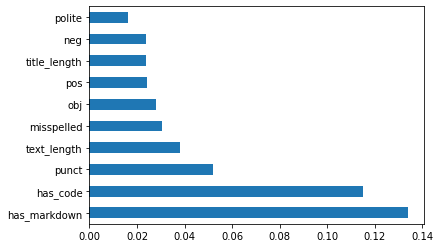

In [254]:
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Здесь видно, что, как правило, самая высокая корреляция именно у выведенных нами фич.

Оставим только признаки, важность которых от 0.001

In [259]:
important_features = feat_importances[feat_importances.ge(0.001)]

In [260]:
important_features

t_sql-server       0.001750
t_tensorflow       0.001994
t_laravel          0.001911
t_asp.net          0.001052
t_visual-studio    0.002212
                     ...   
which              0.002490
what               0.007925
when               0.005003
how                0.010335
why                0.002751
Length: 136, dtype: float64

In [262]:
train_features = train_features[important_features.keys()]
test_features = test_features[important_features.keys()]

In [263]:
train_features.to_csv('data/train_features.csv', index=False)
test_features.to_csv('data/test_features.csv', index=False)

#### Ещё меньше фич

In [1]:
import pandas as pd
import numpy as np

In [26]:
train_features = pd.read_csv('data/train_features.csv')
test_features = pd.read_csv('data/test_features.csv')

In [3]:
train_texts = pd.read_csv('data/train_lemmatized.csv')
y = train_texts['target']

In [4]:
normalized_train=(train_features-train_features.mean())/train_features.std()

In [5]:
from sklearn.ensemble import ExtraTreesClassifier

In [6]:
model = ExtraTreesClassifier()

In [7]:
model.fit(normalized_train, y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [8]:
importance = model.feature_importances_
features = sorted([(i,v) for i,v in enumerate(importance)], key=lambda x:x[1])[::-1]
feat_importances = pd.Series(model.feature_importances_, index=normalized_train.columns)

In [9]:
len(feat_importances)

136

In [10]:
feat_importances

t_sql-server       0.001854
t_tensorflow       0.001830
t_laravel          0.002651
t_asp.net          0.001285
t_visual-studio    0.002588
                     ...   
which              0.003097
what               0.010025
when               0.006078
how                0.012613
why                0.003504
Length: 136, dtype: float64

In [11]:
feat_importances[feat_importances.ge(0.005)]

t_html          0.005350
t_r             0.014401
t_c++           0.005775
t_regex         0.006143
t_c#            0.007046
t_python        0.006384
t_java          0.012890
t_arrays        0.006819
t_c             0.009604
t_php           0.010420
t_go            0.005079
t_io            0.007668
has_code        0.140411
has_markdown    0.133129
punct           0.059575
text_length     0.049684
title_length    0.029648
misspelled      0.038533
pos             0.030867
neg             0.029699
obj             0.035595
thanks          0.011309
enter image     0.005913
component       0.006350
react           0.005677
version         0.009144
build           0.006335
running         0.005017
override        0.005099
polite          0.020169
what            0.010025
when            0.006078
how             0.012613
dtype: float64

In [29]:
important_features = feat_importances[feat_importances.ge(0.01)]

In [30]:
important_features

t_r             0.014401
t_java          0.012890
t_php           0.010420
has_code        0.140411
has_markdown    0.133129
punct           0.059575
text_length     0.049684
title_length    0.029648
misspelled      0.038533
pos             0.030867
neg             0.029699
obj             0.035595
thanks          0.011309
polite          0.020169
what            0.010025
how             0.012613
dtype: float64

In [27]:
train_features = train_features[important_features.keys()]
test_features = test_features[important_features.keys()]

In [28]:
train_features.to_csv('experim_data/train_features_16.csv', index=False)
test_features.to_csv('experim_data/test_features_16.csv', index=False)

С этим финальным набором фич и были получены результаты.